# 10-10. 프로젝트 : 단어 Level로 번역기 업그레이드하기

### 사전 준비

단어 단위(Word-level) 번역기

1. 문자 단위와 다른 전처리
2. 임베딩 층(Embedding layer)를 추가
3. 데이터에서 상위 33,000개의 샘플만 사용(테스트 3,000)

#### import

In [63]:
import os

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Masking
from tensorflow.keras.models import Model

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import re
import random

print(tf.__version__)

2.9.2


#### 함수정의

In [64]:
def preprocess_sentence(sentence):
  ''' 입력된 문장을
  #     1. 소문자로 바꾸고, 양쪽 공백을 지웁니다
  #     2. 특수문자 양쪽에 공백을 넣고
  #     3. 여러개의 공백은 하나의 공백으로 바꿉니다
  #     4. a-zA-Z?.!,¿가 아닌 모든 문자를 하나의 공백으로 바꿉니다
  #     5. 다시 양쪽 공백을 지웁니다
  '''
  sentence = sentence.lower().strip()                    # 1
  sentence = re.sub(r"([?.!,¿])", r" \1 ", sentence)    # 2
  sentence = re.sub(r'[" "]+', " ", sentence)            # 3
  sentence = re.sub(r"[^a-zA-Z?.!,'¿]+", " ", sentence) # 4
  sentence = sentence.strip()                            # 5
  return sentence

# 모델 성과를 그려주는 함수
def plot_model(history):
  history_dict = history.history
  print(history_dict.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들

  acc = history_dict['acc']
  val_acc = history_dict['val_acc']
  loss = history_dict['loss']
  val_loss = history_dict['val_loss']

  epochs = range(1, len(acc) + 1)

  # "bo"는 "파란색 점"입니다
  plt.plot(epochs, loss, 'bo', label='Training loss')
  # b는 "파란 실선"입니다
  plt.plot(epochs, val_loss, 'b', label='Validation loss')
  plt.title('Training and validation loss')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend()
  plt.show()

  plt.clf()   # 그림을 초기화합니다
  plt.plot(epochs, acc, 'bo', label='Training acc')
  plt.plot(epochs, val_acc, 'b', label='Validation acc')
  plt.title('Training and validation accuracy')
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.legend()
  plt.show()

def decode_sequence(input_seq):
  '''디코딩 함수'''

  states_value = encoder_model.predict(input_seq)    # 인코더의 마지막 시점의 상태(은닉 상태, 셀 상태)
  
  # <sos>에 해당하는 정수 생성
  target_seq = np.zeros((1,1))
  target_seq[0, 0] = fra_to_index['<sos>']

  stop_condition = False
  decoded_sentence = ''

  # stop_condition이 True가 될 때까지 루프 반복(간소화를 위해 배치 크기 = 1)
  while not stop_condition:
    # 이점 시점의 상태 states_value를 현 시점의 초기 상태로 사용
    output_tokens, h, c = decoder_model.predict([target_seq] + states_value)

    # 예측 결과를 단어로 변환
    sampled_token_index = np.argmax(output_tokens[0, -1, :])
    sampled_char = index_to_fra[sampled_token_index]

    # 현재 시점의 예측 단어를 예측 문장에 추가
    decoded_sentence += ' '+sampled_char

    # <eos>에 도달하거나 정해진 길이를 넘으면 중단.
    if (sampled_char == '<eos>' or
        len(decoded_sentence) > 50):
        stop_condition = True

    # 현재 시점의 예측 결과를 다음 시점의 입력으로 사용하기 위해 저장
    target_seq = np.zeros((1,1))
    target_seq[0, 0] = sampled_token_index

    # 현재 시점의 상태를 다음 시점의 상태로 사용하기 위해 저장
    states_value = [h, c]

  return decoded_sentence


def seq_to_src(input_seq):
  '''원문의 정수 시퀀스를 텍스트 시퀀스로 변환하는 함수'''
  sentence = ''
  for encoded_word in input_seq:
    if(encoded_word != 0):
      sentence = sentence + index_to_eng[encoded_word] + ' '
  return sentence


def seq_to_tar(input_seq):
  '''# 번역문의 정수 시퀀스를 텍스트 시퀀스로 변환하는 함수'''
  sentence = ''
  for encoded_word in input_seq:
    if(encoded_word != 0 and encoded_word != fra_to_index['<sos>'] and encoded_word != fra_to_index['<eos>']):
      sentence = sentence + index_to_fra[encoded_word] + ' '
  return sentence

## Step 1. 정제, 정규화, 전처리 (영어, 프랑스어 모두!)


- 데이터 불러오기

3. 데이터에서 상위 33,000개의 샘플만 사용(테스트 3,000)

In [65]:
file_path = '/content/drive/MyDrive/Colab Notebooks/Exploration/fra-eng_translation/fra.txt'
lines = pd.read_csv(file_path, names=['eng', 'fra', 'cc'], sep='\t')
print('전체 샘플의 수 :',len(lines))

# 중복 제거
lines.drop_duplicates()

lines = lines[['eng', 'fra']][:33000]           # 3.3만개 샘플 사용
print('사용 샘플의 수 :',len(lines))

lines.sample(5)

전체 샘플의 수 : 197463
사용 샘플의 수 : 33000


,eng,fra
16582,We are his sons.,Nous sommes ses fils.
22338,You're conceited.,Tu es suffisante.
28392,Are you vegetarian?,Êtes-vous végétarienne ?
15587,She scolded him.,Elle l'a sermonné.
1500,Take mine.,Prenez le mien.


- 데이터 정제

In [66]:
# dataframe 안의 문장을 리스트로 받기

raw_corpus_eng = []
raw_corpus_fra = [] 

# 여러개의 txt 파일을 모두 읽어서 raw_corpus 에 담습니다.
for eng_text, fra_text in zip(lines['eng'],lines['fra']):
  raw_corpus_eng.append(eng_text)
  raw_corpus_fra.append(fra_text)


print("데이터 크기:", len(raw_corpus_eng))
print("Examples:\n", raw_corpus_eng[:3])
print("Examples:\n", raw_corpus_fra[:3])

데이터 크기: 33000
Examples:
 ['Go.', 'Go.', 'Go.']
Examples:
 ['Va !', 'Marche.', 'En route !']


- 추가적인 전처리

1. 구두점(Punctuation)을 단어와 분리  

2. 띄어쓰기 단위로 단어를 분리 (토큰화(Tokenization))  
; 예) 'he is a good boy!' -> ['he', 'is', 'a', 'good', 'boy', '!']

3. 소문자로 바꾸기


In [67]:
# 구두점 띄고 기타 특수문자 제거

corpus_eng = []
corpus_fra = []

# eng 데이터 전처리
for sentence in raw_corpus_eng:
    # 우리가 원하지 않는 문장은 건너뜁니다
    if len(sentence) == 0: continue
    if sentence[-1] == ":": continue
    
    # 앞서 구현한 preprocess_sentence() 함수를 이용하여 문장을 정제를 하고 담아주세요
    preprocessed_sentence = preprocess_sentence(sentence)
    corpus_eng.append(list(preprocessed_sentence.split()))

# fra 다시한번
for sentence in raw_corpus_fra:
    if len(sentence) == 0: continue
    if sentence[-1] == ":": continue
    
    preprocessed_sentence = preprocess_sentence(sentence)
    corpus_fra.append(list(preprocessed_sentence.split()))
        


In [68]:
corpus_eng[:10]
# corpus_fra[:10]

[['go', '.'],
 ['go', '.'],
 ['go', '.'],
 ['go', '.'],
 ['hi', '.'],
 ['hi', '.'],
 ['run', '!'],
 ['run', '!'],
 ['run', '!'],
 ['run', '!']]

## Step 2. 디코더의 문장에 시작 토큰과 종료 토큰을 넣어주세요.


디코더의 입력 시퀀스 맨 앞 : 시작을 의미하는 토큰 필요  
교사 강요를 수행 시 : 디코더의 레이블 시퀀스에 종료 토큰 필요

예) ['courez', '!'] ->  
    입력 시퀀스 : ['', 'courez', '!']  
    레이블 시퀀스 : ['courez', '!', ']  

Step 1을 수행하는 중간에 수행해도 상관없음.

In [69]:
sos_token = '<sos>'          # 시작 토큰
eos_token = '<eos>'          # 종료 토큰

decoder = []

for i, sentense in enumerate(corpus_fra):
  # 입력, 출력 시퀀스 넣기
  de_sen = [sos_token] + sentense + [eos_token]
  decoder.append(de_sen)

decoder[:3]


[['<sos>', 'va', '!', '<eos>'],
 ['<sos>', 'marche', '.', '<eos>'],
 ['<sos>', 'en', 'route', '!', '<eos>']]

## Step 3. 케라스의 토크나이저로 텍스트를 숫자로 바꿔보세요.


케라스 토크나이저 - 단어를 고유한 정수로 변환  
참고 : https://wikidocs.net/31766  

1. 영어와 프랑스어 토크나이저 각각 생성
2. tokenizer.texts_to_sequences() 사용 - 모든 샘플을 정수 시퀀스로 변환

- eng

In [70]:
eng_tokenizer = Tokenizer(filters='')                   # 단어 단위로 Tokenizer를 생성합니다. 
eng_tokenizer.fit_on_texts(corpus_eng)               
input_text = eng_tokenizer.texts_to_sequences(corpus_eng)    # 단어를 숫자값 인덱스로 변환하여 저장
input_text[123:126]

[[323, 1], [31, 178, 20], [31, 178, 20]]

- fra

In [71]:
fra_tokenizer = Tokenizer(filters='')                     
fra_tokenizer.fit_on_texts(decoder)               
target_text = fra_tokenizer.texts_to_sequences(decoder)  
target_text[123:126]

[[1, 1021, 7, 2], [1, 19, 10, 1098, 7, 2], [1, 1958, 7, 2]]

- 단어장 살펴보기

In [72]:
eng_vocab_size = len(eng_tokenizer.word_index) + 1
fra_vocab_size = len(fra_tokenizer.word_index) + 1
print('영어 단어장의 크기 :', eng_vocab_size)
print('프랑스어 단어장의 크기 :', fra_vocab_size)

영어 단어장의 크기 : 4771
프랑스어 단어장의 크기 : 7972


In [73]:
eng_to_index = eng_tokenizer.word_index
index_to_eng = eng_tokenizer.index_word
fra_to_index = fra_tokenizer.word_index
index_to_fra = fra_tokenizer.index_word
index_to_fra[2]

'<eos>'

- 영어 데이터와 프랑스어 데이터의 최대 길이



In [74]:
max_eng_seq_len = max([len(line) for line in input_text])
max_fra_seq_len = max([len(line) for line in target_text])
print('영어 시퀀스의 최대 길이', max_eng_seq_len)
print('프랑스어 시퀀스의 최대 길이', max_fra_seq_len)

영어 시퀀스의 최대 길이 8
프랑스어 시퀀스의 최대 길이 16


- 종합 정보

In [75]:
print('전체 샘플의 수 :',len(lines))
print('영어 단어장의 크기 :', eng_vocab_size)
print('프랑스어 단어장의 크기 :', fra_vocab_size)
print('영어 시퀀스의 최대 길이', max_eng_seq_len)
print('프랑스어 시퀀스의 최대 길이', max_fra_seq_len)

전체 샘플의 수 : 33000
영어 단어장의 크기 : 4771
프랑스어 단어장의 크기 : 7972
영어 시퀀스의 최대 길이 8
프랑스어 시퀀스의 최대 길이 16


- fra 시퀀스 ; 2가지 버전으로 나누기 

In [76]:
encoder_input = input_text
# 종료 토큰 제거
decoder_input = [[ char for char in line if char != fra_tokenizer.word_index[eos_token] ] for line in target_text] 
# 시작 토큰 제거
decoder_target = [[ char for char in line if char != fra_tokenizer.word_index[sos_token] ] for line in target_text]

In [77]:
print(decoder_input[:3])
print(decoder_target[:3])

[[1, 70, 7], [1, 384, 3], [1, 26, 541, 7]]
[[70, 7, 2], [384, 3, 2], [26, 541, 7, 2]]


- pad 붙이기

In [78]:
encoder_input = pad_sequences(encoder_input, maxlen = max_eng_seq_len, padding='post')
decoder_input = pad_sequences(decoder_input, maxlen = max_fra_seq_len, padding='post')
decoder_target = pad_sequences(decoder_target, maxlen = max_fra_seq_len, padding='post')
print('영어 데이터의 크기(shape) :',np.shape(encoder_input))
print('프랑스어 입력데이터의 크기(shape) :',np.shape(decoder_input))
print('프랑스어 출력데이터의 크기(shape) :',np.shape(decoder_target))

영어 데이터의 크기(shape) : (33000, 8)
프랑스어 입력데이터의 크기(shape) : (33000, 16)
프랑스어 출력데이터의 크기(shape) : (33000, 16)


훈련과정의 validation을 위해 위에서 생성한 데이터 50000건 중 3000건만 검증데이터로 삼고, 나머지를 학습데이터로 삼겠습니다.

In [79]:
n_of_val = 3000

encoder_input_train = encoder_input[:-n_of_val]
decoder_input_train = decoder_input[:-n_of_val]
decoder_target_train = decoder_target[:-n_of_val]

encoder_input_test = encoder_input[-n_of_val:]
decoder_input_test = decoder_input[-n_of_val:]
decoder_target_test = decoder_target[-n_of_val:]

print('영어 학습데이터의 크기(shape) :',np.shape(encoder_input_train))
print('프랑스어 학습 입력데이터의 크기(shape) :',np.shape(decoder_input_train))
print('프랑스어 학습 출력데이터의 크기(shape) :',np.shape(decoder_target_train))

영어 학습데이터의 크기(shape) : (30000, 8)
프랑스어 학습 입력데이터의 크기(shape) : (30000, 16)
프랑스어 학습 출력데이터의 크기(shape) : (30000, 16)


## Step 4. 임베딩 층(Embedding layer) 사용하기


각 단어를 임베딩 층을 사용하여 벡터화  
참고 : https://wikidocs.net/33793  

1. 케라스 임베딩 층(Keras Embedding layer) 참고  
  ; 이를 통해서 인코더와 디코더의 임베딩 층을 각각 구현

--- > 모델구현 시 임베딩 함께 고려.

## Step 5. 모델 구현하기


In [80]:
# 임베딩 벡터의 차원과 LSTM의 은닉 상태의 크기를 64로 사용

embedding_dim = 128
hidden_units = 128

- encoder

In [81]:
# 인코더
encoder_inputs = Input(shape=(None,))         # 입력 텐서 생성.
enc_emb = Embedding(eng_vocab_size, embedding_dim)(encoder_inputs) # 임베딩 층
enc_masking = Masking(mask_value=0.0)(enc_emb) # 패딩 0은 연산에서 제외
encoder_lstm = LSTM(hidden_units, return_state=True) # 상태값 리턴을 위해 return_state는 True
encoder_outputs, state_h, state_c = encoder_lstm(enc_masking) # 은닉 상태와 셀 상태를 리턴
encoder_states = [state_h, state_c] # 인코더의 은닉 상태와 셀 상태를 저장

- decoder

In [82]:
# 디코더
decoder_inputs = Input(shape=(None,))
dec_emb_layer = Embedding(fra_vocab_size, hidden_units) # 임베딩 층
dec_emb = dec_emb_layer(decoder_inputs) # 패딩 0은 연산에서 제외
dec_masking = Masking(mask_value=0.0)(dec_emb)
decoder_lstm = LSTM(hidden_units
                    , return_sequences=True    # 상태값 리턴(return_state=True),
                    , return_state=True)       # 모든 시점에 단어 예측(return_sequences= True) 
decoder_outputs, _, _ = decoder_lstm(dec_masking
                                    ,initial_state=encoder_states)  # 초기 은닉 상태(encoder_state)
decoder_dense = Dense(fra_vocab_size, activation='softmax') # softmax
decoder_outputs = decoder_dense(decoder_outputs)

In [83]:
# 모델의 입력과 출력을 정의.
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy', metrics=['acc'], run_eagerly=True)

In [84]:
# 모델 확인
model.summary()

Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_9 (InputLayer)           [(None, None)]       0           []                               
                                                                                                  
 input_10 (InputLayer)          [(None, None)]       0           []                               
                                                                                                  
 embedding_6 (Embedding)        (None, None, 128)    610688      ['input_9[0][0]']                
                                                                                                  
 embedding_7 (Embedding)        (None, None, 128)    1020416     ['input_10[0][0]']               
                                                                                            

In [85]:
# 모델 학습 
history = model.fit(x=[encoder_input_train, decoder_input_train]
                  , y=decoder_target_train
                  , validation_data = ([encoder_input_test
                                      , decoder_input_test]
                                      , decoder_target_test)
                  , batch_size=128
                  , epochs=29               # 29 정도가 적당
                  )

Epoch 1/29
235/235 [==============================] - 14s 61ms/step - loss: 2.1748 - acc: 0.6912 - val_loss: 1.9172 - val_acc: 0.7163
Epoch 2/29
235/235 [==============================] - 14s 59ms/step - loss: 1.5223 - acc: 0.7601 - val_loss: 1.7854 - val_acc: 0.7349
Epoch 3/29
235/235 [==============================] - 14s 59ms/step - loss: 1.3603 - acc: 0.7820 - val_loss: 1.6330 - val_acc: 0.7527
Epoch 4/29
235/235 [==============================] - 14s 59ms/step - loss: 1.2333 - acc: 0.8019 - val_loss: 1.5549 - val_acc: 0.7654
Epoch 5/29
235/235 [==============================] - 14s 58ms/step - loss: 1.1451 - acc: 0.8142 - val_loss: 1.4717 - val_acc: 0.7756
Epoch 6/29
235/235 [==============================] - 14s 58ms/step - loss: 1.0780 - acc: 0.8227 - val_loss: 1.4236 - val_acc: 0.7836
Epoch 7/29
235/235 [==============================] - 14s 60ms/step - loss: 1.0227 - acc: 0.8296 - val_loss: 1.3840 - val_acc: 0.7882
Epoch 8/29
235/235 [==============================] - 14s 60ms

dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])


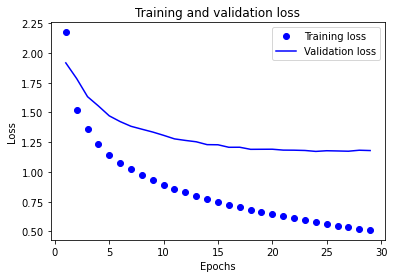

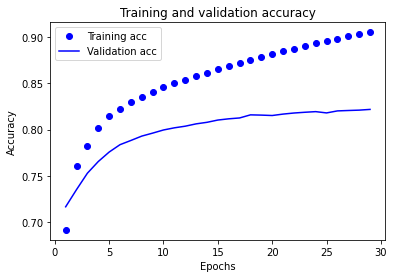

In [86]:
plot_model(history)


In [87]:
print(history.history['val_acc'][-1])

0.8218958377838135


val_acc = 82.3% 정도로 학습됨.

## Step 6. 모델 평가하기


단어 단위 번역기에 대해서 
1. 훈련 데이터의 샘플
2. 테스트 데이터의 샘플  
번역 문장 만들고 정답과 비교  
  
Embedding layer 추가로 학습 내용 그대로 사용시 shape에서 error 발생.
- decode sentence 구성 시 고민하기.

In [88]:
# 인코더
encoder_model = Model(encoder_inputs, encoder_states)

# 디코더 설계 시작
# 이전 시점의 상태를 보관할 텐서
decoder_state_input_h = Input(shape=(hidden_units,))
decoder_state_input_c = Input(shape=(hidden_units,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

# 훈련 때 사용했던 임베딩 층을 재사용
dec_emb2 = dec_emb_layer(decoder_inputs)

# 다음 단어 예측을 위해 이전 시점의 상태를 현 시점의 초기 상태로 사용
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=decoder_states_inputs)
decoder_states2 = [state_h2, state_c2]

# 모든 시점에 대해서 단어 예측
decoder_outputs2 = decoder_dense(decoder_outputs2)

# 수정된 디코더
decoder_model = Model(
    [decoder_inputs] + decoder_states_inputs,
    [decoder_outputs2] + decoder_states2)

- 학습 데이터에서 모델 평가하기

In [98]:
# 랜덤 5개 문장
for seq_index in random.sample((range(len(encoder_input_train))), 5):
  input_seq = encoder_input_train[seq_index: seq_index + 1]
  decoded_sentence = decode_sequence(input_seq)

  print("입력문장 :",seq_to_src(encoder_input_train[seq_index]))
  print("정답문장 :",seq_to_tar(decoder_input_train[seq_index]))
  print("번역문장 :",decoded_sentence[1:-5])
  print("-"*50)

1/1 [==============================] - 0s 17ms/step
입력문장 : no one can say . 
정답문장 : personne ne peut le dire . 
번역문장 : personne ne peut le dire . 
--------------------------------------------------
1/1 [==============================] - 0s 15ms/step
입력문장 : send tom over . 
정답문장 : fais venir tom . 
번역문장 : fais entrer tom . 
--------------------------------------------------
1/1 [==============================] - 0s 15ms/step
입력문장 : we're all scared . 
정답문장 : nous avons toutes peur . 
번역문장 : nous avons tous peur . 
--------------------------------------------------
1/1 [==============================] - 0s 18ms/step
입력문장 : no one knows . 
정답문장 : personne ne sait . 
번역문장 : personne ne sait . 
--------------------------------------------------
1/1 [==============================] - 0s 15ms/step
입력문장 : is anyone looking ? 
정답문장 : quiconque regarde t il ? 
번역문장 : quiconque est il l ? 
--------------------------------------------------



입력문장 : no one can say .  (아무도 말할 수 없습니다.)  
정답문장 : personne ne peut le dire . (아무도 말할 수 없습니다.)  
번역문장 : personne ne peut le dire . (상동)   

****  
입력문장 : send tom over . (톰을 보내)  
정답문장 : fais venir tom . (톰을 데려와)  
번역문장 : fais entrer tom . (톰을 들여보내줘.)  
****  
입력문장 : we're all scared . (우리는 모두 두려워합니다.)  
정답문장 : nous avons toutes peur .(우리 모두 두려워)   
번역문장 : nous avons tous peur . (우리 모두 두려워)  
****
입력문장 : no one knows . (아무도 모른다.)  
정답문장 : personne ne sait . (아무도 모른다.
)  
번역문장 : personne ne sait . (상동)   
****
입력문장 : is anyone looking ? (누군가 찾고 있습니까?)  
정답문장 : quiconque regarde t il ? (보고 있는 사람?)  
번역문장 : quiconque est il l ? (누가 거기 있어?)  

- 테스트 데이터에서 모델 평가하기

In [97]:
# 랜덤 5개 문장
for seq_index in random.sample((range(len(encoder_input_test))), 5):
  input_seq = encoder_input_test[seq_index: seq_index + 1]
  decoded_sentence = decode_sequence(input_seq)

  print("입력문장 :",seq_to_src(encoder_input_test[seq_index]))
  print("정답문장 :",seq_to_tar(decoder_input_test[seq_index]))
  print("번역문장 :",decoded_sentence[1:-5])
  print("-"*50)

1/1 [==============================] - 0s 16ms/step
입력문장 : tom is downhearted . 
정답문장 : tom a le c ur lourd . 
번역문장 : tom est d range . 
--------------------------------------------------
1/1 [==============================] - 0s 16ms/step
입력문장 : save your strength . 
정답문장 : conomise tes forces . 
번역문장 : suis votre yeux . 
--------------------------------------------------
1/1 [==============================] - 0s 15ms/step
입력문장 : it's a big concern . 
정답문장 : c'est une grande pr occupation . 
번역문장 : c'est une grande journ e . 
--------------------------------------------------
1/1 [==============================] - 0s 16ms/step
입력문장 : i never blamed you . 
정답문장 : je ne t'ai jamais bl m . 
번역문장 : je ne vous jamais fait jamais . 
--------------------------------------------------
1/1 [==============================] - 0s 16ms/step
입력문장 : look at my new car . 
정답문장 : regardez ma nouvelle voiture . 
번역문장 : regarde ma chambre . 
--------------------------------------------------


입력문장 : tom is downhearted . (톰은 낙심했다.)  

정답문장 : tom a le c ur lourd . (톰은 마음이 무겁습니다.)  
번역문장 : tom est d range . (톰이 고장났습니다.)  

****
입력문장 : save your strength . (당신의 힘을 저장하세요.)  
정답문장 : conomise tes forces . (당신의 힘을 저장합니다.)  
번역문장 : suis votre yeux . (당신의 눈을 따르십시오.)
****
입력문장 : it's a big concern . (큰 걱정거리입니다.)  
정답문장 : c'est une grande pr occupation .(이것은 큰 관심사입니다.)  
번역문장 : c'est une grande journ e . (큰일이다.)  
****
입력문장 : i never blamed you . (나는 당신을 비난한 적이 없습니다.)  
정답문장 : je ne t'ai jamais bl m . ( 나는 당신을 비난하지 않습니다.)  
번역문장 : je ne vous jamais fait jamais .(
나는 당신을 한 적이 없습니다.)   
****
입력문장 : look at my new car . (내 새 차를 봐.)  
정답문장 : regardez ma nouvelle voiture . (내 새 차를 봐.)  

번역문장 : regarde ma chambre . (내 방 좀 봐.
)